## Scikit-learn - prediktívne modelovanie pomocou algoritmu k-najbližších susedov

Cieľom príkladov v tejto lekcii je demonštrovať vytvorenie klasifikačného modelu k najbližších susedov na databáze Titanic. Ako cieľový atribút zvolíme `survived` a vytvorený klasikifačný model bude schopný na základe údajov o cestujúcich predikovať, či daný cestujúci prežil potopenie lode alebo nie. 

Cieľom posledného cvičenia bolo oboznámiť sa so základným postupom práce s knižnicou Scikit-learn. Ako ukážkový klasifikátor bol použitý algoritmus k najbližších susedov. V ukážkovej úlohe (aj na domácej úlohe) sme pracovali s datasetmi, ktoré obsahovali iba numerické atribúty a dáta sme nijak pred aplikovaním modelovania nepredspracovali. 

V rámci tohoto cvičenia si na úlohe predikcie atribútu `survived` datasetu Titanic ukážeme podrobnejšie prácu s k-NN. To bude okrem nastavenia rôznych parametrov algoritmu zahŕňať aj to, ako je nutné dáta pred aplikáciou kNN predspracovať a akými rôznymi spôsobmi je možné model kvalitatívne vyhodnotiť. 

Najprv teda naimportujeme všetky potrebné knižnice.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Teraz načítajte do dátového rámca `titanic` predspracované dáta z datasetu Titanic, z cvičenia č. 7. Nachádzajú sa v súbore `../data/titanic-processed.csv`.
 
Vypíšte pomocou funkcie `head()` prvých 5 príkladov aby sme videli, aké atribúty máme popísané dáta v datasete. 

In [2]:
# YOUR CODE HERE

titanic = pd.read_csv("../data/titanic-processed.csv")
titanic.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family,has_family,fare_ordinal,title,title_short,age_ordinal,deck
0,1,1,female,29.00,0,0,24160,211.3375,B5,Southampton,0,False,most expensive,Miss,Miss,adult,B
1,1,1,male,0.92,1,2,113781,151.5500,C22 C26,Southampton,3,True,most expensive,Master,rare title,child,C
2,1,0,female,2.00,1,2,113781,151.5500,C22 C26,Southampton,3,True,most expensive,Miss,Miss,child,C
3,1,0,male,30.00,1,2,113781,151.5500,C22 C26,Southampton,3,True,most expensive,Mr,Mr,adult,C
4,1,0,female,25.00,1,2,113781,151.5500,C22 C26,Southampton,3,True,most expensive,Mrs,Mrs,adult,C


In [3]:
titanic.isnull().sum()

pclass             0
survived           0
sex                0
age                0
sibsp              0
parch              0
ticket             0
fare               0
cabin           1014
embarked           0
family             0
has_family         0
fare_ordinal       0
title              0
title_short        0
age_ordinal        0
deck            1014
dtype: int64

Dataset Titanic obsahuje okrem numerických aj kategorické atribúty. Takéto atribúty model k-NN nie je schopný spracovať. Pre použitie modelu k-najbližších susedov preto budeme musieť najprv vytvorené dáta vhodne transformovať. 

Okrem toho z datasetu môžeme odstrániť niektoré atribúty. Číslo lístka zrejme nebude mať výrazný vplyv na klasifikáciu, tak môžeme atribút `ticket` odstrániť. Atribút `title` môžeme odstrániť tiež, keďže budeme používať atribút `title_short`, ktorý vznikol jeho transformovaním. Odstránime aj atribúty `deck` a `cabin`, keďže obsahujú obrovské množstvo chýbajúcich hodnôt, ktoré nemáme ako nahradiť. 

Na uvedené transformácie použite funkciu `drop` nad dátovým rámcom `titanic`. 

In [4]:
# YOUR CODE HERE

titanic = titanic.drop(columns=['cabin','deck','ticket','title'])
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,family,has_family,fare_ordinal,title_short,age_ordinal
0,1,1,female,29.00,0,0,211.3375,Southampton,0,False,most expensive,Miss,adult
1,1,1,male,0.92,1,2,151.5500,Southampton,3,True,most expensive,rare title,child
2,1,0,female,2.00,1,2,151.5500,Southampton,3,True,most expensive,Miss,child
3,1,0,male,30.00,1,2,151.5500,Southampton,3,True,most expensive,Mr,adult
4,1,0,female,25.00,1,2,151.5500,Southampton,3,True,most expensive,Mrs,adult


### Transformácia atribútov

V nasledujúcich krokoch si ukážeme, ako môžeme atribúty v nevyhovujúcej forme pretransformovať. 

Nasledujúce atribúty obsahujú ako hodnoty reťazce a nemôžu byť v takejto podobe použité pri modelovaní k-NN:
* `sex`
* `embarked`
* `has_family`
* `fare_ordinal`
* `title_short`
* `age_ordinal`

#### Transformácia binárnych (kategorických) atribútov na nominálne pomocou `LabelEncoder`

Atribúty `sex` a `has_family` sú atribúty nadobúdajúce 2 hodnoty. Môžeme teda použiť jednoduchú transformáciu, ktorá ich hodnoty nahradí celým číslom. Na takúto operáciu môžeme použiť `LabelEncoder` z knižnice Scikit-learn. Ten pomocou funkcie `fit_transform()` pre atribút zadaný ako parameter nahradí všetky rôzne hodnoty indexom.  

Rovnako by sme ale mohli použiť transformáciu pomocou dátových rámcov a funkcie `map()`. V zakomentovanej časti je kód, ktorý realizuje identickú operáciu pomocou `map()` funkcie ako použitím Label Encoderu. 

In [5]:
from sklearn.preprocessing import LabelEncoder # najprv importujeme potrebné funkcie

titanic['sex'] = LabelEncoder().fit_transform(titanic['sex']) # vytvoríme LabelEncoder, použijeme ho na stĺpec `sex`, výsledok zapíšeme do titanic[`sex`]
#titanic['has_family'] = LabelEncoder().fit_transform(titanic['has_family']) # vytvoríme LabelEncoder a aplikujeme ho na stĺpec `has_family`, výsledok zapíšeme do titanic[`has_family`]

## rovnaká transformácia pomocou funkcie map()
# titanic['sex'] = titanic['sex'].map({"male": 0, "female": 1})
titanic['has_family'] = titanic['has_family'].map({False: 0, True: 1})

titanic.head() # vypíšeme prvých 5 záznamov z dátového rámca a overíme transformáciu

,pclass,survived,sex,age,sibsp,parch,fare,embarked,family,has_family,fare_ordinal,title_short,age_ordinal
0,1,1,0,29.00,0,0,211.3375,Southampton,0,0,most expensive,Miss,adult
1,1,1,1,0.92,1,2,151.5500,Southampton,3,1,most expensive,rare title,child
2,1,0,0,2.00,1,2,151.5500,Southampton,3,1,most expensive,Miss,child
3,1,0,1,30.00,1,2,151.5500,Southampton,3,1,most expensive,Mr,adult
4,1,0,0,25.00,1,2,151.5500,Southampton,3,1,most expensive,Mrs,adult


#### Transformácia numerických atribútov na kategorické pomocou spôsobu `One Hot Encoding`

Nie všetky atribúty je vhodné transformovať jednoduchým enkodérom (priradením číselných hodnôt pre rôzne hodnoty kategorického atribútu). Pri kategorických atribútoch s viacerými ako 2 hodnotami tak "nechtiac" vytvárame ich poradie. Niektoré modely (aj vrátane k-NN) by potom takto transformovaný atribút mohlo brať ako ordinálny, hoci v pôvodnom atribúte pred transformáciou žiadne usporiadanie neexistovalo. Ak sa tomu chceme vyhnúť, môžeme použiť tzv. One Hot Encoding. Pri takejto transformácii sa pre každú hodnotu kategorického atribútu odvodí nový, binárny atribút, ktorý bude špecifikovať, či príklady danú hodnotu nadobúdajú alebo nie. 

Takéto zakódovanie môžeme v pythone realizovať aj pomocou funkcie `get_dummies()` dátového rámca Pandas. Jej parametrami sú dátový rámec, s ktorým pracujeme a zoznam stĺpcov, ktoré chceme transformovať.  

V našom prípade takto transformujeme atribúty `embarked` a `title_short`, nakoľko v oboch prípadoch ide o kategorické atribúty, ktoré nemajú usporiadanie. 

In [6]:
titanic = pd.get_dummies(titanic, columns=['embarked', 'title_short']) # funkcii get_dummies špecifikujeme, ktoré atribúty chceme zakódovať na binárne
titanic.head() # vypíšeme prvých 5 záznamov a overíme transformáciu

,pclass,survived,sex,age,sibsp,parch,fare,family,has_family,fare_ordinal,age_ordinal,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton,title_short_Miss,title_short_Mr,title_short_Mrs,title_short_rare title
0,1,1,0,29.00,0,0,211.3375,0,0,most expensive,adult,0,0,1,1,0,0,0
1,1,1,1,0.92,1,2,151.5500,3,1,most expensive,child,0,0,1,0,0,0,1
2,1,0,0,2.00,1,2,151.5500,3,1,most expensive,child,0,0,1,1,0,0,0
3,1,0,1,30.00,1,2,151.5500,3,1,most expensive,adult,0,0,1,0,1,0,0
4,1,0,0,25.00,1,2,151.5500,3,1,most expensive,adult,0,0,1,0,0,1,0


#### Transformácia ordinálnych kategorických atribútov na numerické

Po uvedených transformáciách nám stále zostali 2 atribúty, ktoré je potrebné transformovať na numerické. V oboch prípadoch sa jedná o ordinálne kategorické atribúty, teda atribúty s jasne definovaným usporiadaním. Pre takéto atribúty môžeme použiť zakódovanie ako v prípade transformácie atribútov `sex` alebo `has_family`, no vzhľadom na existujúce usporiadanie hodnôt musíme špecifikovať zakódovanie manuálne. 

V prípade atribútov `fare_ordinal` a `age_ordinal` teda nadefinujeme ako nahradíme pôvodné hodnoty indexami. V prípade atribútu `fare_ordinal` je usporiadanie jeho hodnôt v poradí `normal` < `more expensive` < `most expensive` a tak týmto hodnotám priradíme indexy 0, 1, resp. 2, čím sa zachová usporiadanie. Analogicky budeme postupovať v prípade atribútu `age_ordinal`.

In [7]:
titanic['fare_ordinal'] = titanic['fare_ordinal'].map({"normal": 0, "more expensive": 1, "most expensive": 2}) # transformujeme atribút tare_ordinal
titanic['age_ordinal'] = titanic['age_ordinal'].map({"child": 0, "young": 1, "adult": 2, "old": 3}) # transformujeme atribút age_ordinal

In [8]:
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,family,has_family,fare_ordinal,age_ordinal,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton,title_short_Miss,title_short_Mr,title_short_Mrs,title_short_rare title
0,1,1,0,29.00,0,0,211.3375,0,0,2,2,0,0,1,1,0,0,0
1,1,1,1,0.92,1,2,151.5500,3,1,2,0,0,0,1,0,0,0,1
2,1,0,0,2.00,1,2,151.5500,3,1,2,0,0,0,1,1,0,0,0
3,1,0,1,30.00,1,2,151.5500,3,1,2,2,0,0,1,0,1,0,0
4,1,0,0,25.00,1,2,151.5500,3,1,2,2,0,0,1,0,0,1,0


### Modelovanie

Na takto predspracovanej množine už môžeme vyskúšať natrénovať klasifikačný model. Podobne ako v predchádzajúcom cvičení najprv rozdelíme dáta do matice príznakov a vektora hodnôt cieľového atribútu.
Cieľovým atribútom v tejto úlohe je `survived` (vyjadruje, či daný pasažier nehodu prežil alebo nie). Cieľový atribút teda bude tvoriť vektor hodnôt `y` a zostávajúce stĺpce maticu príznakov `X`.

In [9]:
X_titanic = titanic.drop('survived', axis=1) # vytvoríme maticu príznakov - použijeme všetky stĺpce okrem cieľového atribútu a uložíme do X_titanic
y_titanic = titanic['survived'] # vytvoríme vektor hodnôt cieľového atribútu ako stĺpec 'survived'

print(X_titanic.shape) # pre kontrolu môžeme vypísať rozmery matice hodnôt a vektora cieľového atribútu
print(y_titanic.shape)

(1309, 17)
(1309,)


Teraz rozdelíme dáta do trénovacej a testovacej množiny. Podstatné je, aby sme všetko predspracovanie (transformácie atribútov atď.) robili pred týmto krokom resp. ak neskôr, musíme si dať pozor, aby sme rovnaké postupy aplikovali jak na trénovaciu, tak testovaciu množinu. Obe z množín musia byť v rovnakom formáte, aby bolo natrénovaný model možné na testovacej množine evaluovať. 

Na rozdelenie dát na trénovacie a testovacie použijeme funkciu `train_test_split()`, tesovacia množina bude v pomere 30/70 k trénovacej.

In [10]:
from sklearn.model_selection import train_test_split # importujeme funkciu train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=1) # rozdelíme dataset do trénovacej a testovacej časti, tak že testovacia bude 30% z celkového datasetu

### Vyhodnotenie pomocou metrík `accuracy`, `precision`, `recall`.

Ďalej natrénujeme model k-NN s defaultne nastavenými parametrami. Model natrénujeme na trénovacej množine (`Xtrain` a `y_train`) a pomocou funkcie `predict()` vyhodnotíme jeho kvalitu na testovacej množine a vypíšeme jeho presnosť (accuracy) a tentoraz aj metriky precision a recall. 

In [11]:
from sklearn.neighbors import KNeighborsClassifier # Importovanie triedy zodpovedajúcej modelu, ktorý budeme trénovať

model = KNeighborsClassifier()                     # Natrénovanie modelu kNN  
model.fit(X_train, y_train)                          # Trénovanie modelu na trénovacej množine 
y_model = model.predict(X_test)   

from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f"Presnosť (accuracy) modelu: {accuracy_score(y_test, y_model)}")
print(f"Presnosť (precision) modelu: {precision_score(y_test, y_model)}")
print(f"Návratnosť (recall) modelu: {recall_score(y_test, y_model)}")

Presnosť (accuracy) modelu: 0.6743002544529262
Presnosť (precision) modelu: 0.6090225563909775
Návratnosť (recall) modelu: 0.5159235668789809


Pomocou funkcie `confusion_matrix()` sa môžeme pozrieť, ako klasifikátor klasifikoval jednotlivé triedy a kde dochádzalo k najväčšej chybe.

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_model)
print(cm)

[[184  52]
 [ 76  81]]


#### Vyhodnotenie modelov pomocou ROC krivky

ROC krivku môžeme pomocou Scikit-learn vypočítať funkciou `roc_curve()`. Jej vstupnými parametrami sú:
* - vektor hodnôt cieľového atribútu testovacej množiny
* - vektor modelom predikovaných hodnôt cieľového atribútu
* - parameter `pos_label` - indikuje pozitívnu hodnotu

Výstupom funkcie sú `tpr`, `fpr` a `threshold`, ktoré predstavujú hodnoty relatívna početnosť skutočne pozitívních príkladov (True Positive Rate) a relatívna početnosť falošne pozitívnych prípadov (False Positive Rate) a hodnoty prahu.
Funkcia `auc()` potom vypočíta AUC hodnotu. 
Samotnú ROC krivku potom môžeme vykresliť pomocou matplotlib. 

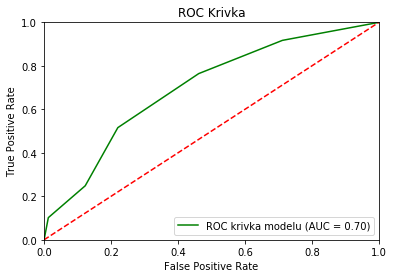

In [14]:
from sklearn.metrics import roc_curve,auc # z Scikit learn importujeme funkcie pre výpočet ROC krivky a AUC koeficientu

# pomocou funkcie roc_curve vypočítame:
# fpr - false positive rate
# tpr - true positive rate
# thresholds - zoznam

y_model_probs = model.predict_proba(X_test) # spočitame pravdepodobnosti pre klasifikáciu do jednej resp. druhej triedy
preds = y_model_probs[:,1] # ponecháme iba jeden stĺpec
fpr, tpr, threshold = roc_curve(y_test, preds) # spočítame koeficienty FPR, TPR

roc_auc = auc(fpr, tpr) # výpočet AUC koeficientu

# pomocou matplotlib vykreslíme ROC krivku
plt.title('ROC Krivka') # definujeme názov obrázku

# vykreslíme ROC krivku, farbou "navy" (môžeme použiť ako parameter názov farby), vypíšeme do legendy AUC koeficient
plt.plot(fpr, tpr, color='green', label = 'ROC krivka modelu (AUC = %0.2f)' % roc_auc) 

plt.legend(loc = 'lower right') # nastavíme vykreslenie legendy vpravo dole
plt.plot([0, 1], [0, 1],linestyle='--', color='red') # vykreslíme červenou (r) prerušovanou farbou diagonálu
plt.xlim([0, 1]) # os x bude nadobúdať hodnoty od 0 do 1
plt.ylim([0, 1]) # os y bude nadobúdať hodnoty od 0 do 1
plt.ylabel('True Positive Rate') # jednotlivé osi otitulkujeme
plt.xlabel('False Positive Rate') # jednotlivé osi otitulkujeme
plt.show() # zobrazíme obrázok

Keďže je klasifikátor k-NN náchylný na mierky numerických atribútov, je vhodné zabezpečiť, aby jednotlivé atribúty mali rovnaký vplyv pri výpočte, resp. aby vďaka rôznym škálam jednotlivých atribútov nedochádzalo k potlačeniu niektorých z nich, resp. naopak aby niektoré neboli výraznejšie. 

Toto je možné dosiahnuť normalizáciou numerických atribútov, ktorá číselný atribút v určitom rozsahu normalizuje na definovaný interval. Je dobré použiť jednotný typ normalizácie pre všetky atribúty, ktoré tak budú nadobúdať hodnoty rovnakom rozsahu. 

### Normalizácia atribútov

Pri preskúmaní transformovaného datasetu zistíme, že 2 atribúty `fare` a `age` nadpbúdajú výrazne odlišnejšie hodnoty od ostatných atribútov.

Normzalizáciu môžeme použiť pomocou transformácie `MinMaxScaler`. Tú možeme v tomto prípade aplikovať na vybrané atribúty, alebo na celý dátový rámec. V našom prípade aplikujeme na všetky atribúty. Normalizované dáta uložíme do dátového rámca `normData`.

In [16]:
from sklearn.preprocessing import MinMaxScaler # importujeme knižnice potrebné pre MinMaxScaler

scaler = MinMaxScaler() #inicializujeme transformáciu
titanic['fare'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(titanic['fare'])), columns=['fare']) 
titanic['age'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(titanic['age'])), columns=['age']) #použijeme transformátor na dátový rámec titanic, výsledok (pole) transforujeme naspať do dátového rámca v rovnakej štruktúre ako pôvodný rámec
titanic.head() # vypíšeme prvých 5 záznamov pre kontrolu
normData = titanic

,pclass,survived,sex,age,sibsp,parch,fare,family,has_family,fare_ordinal,age_ordinal,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton,title_short_Miss,title_short_Mr,title_short_Mrs,title_short_rare title
0,1,1,0,0.361142,0,0,0.412503,0,0,2,2,0,0,1,1,0,0,0
1,1,1,1,0.009395,1,2,0.295806,3,1,2,0,0,0,1,0,0,0,1
2,1,0,0,0.022924,1,2,0.295806,3,1,2,0,0,0,1,1,0,0,0
3,1,0,1,0.373669,1,2,0.295806,3,1,2,2,0,0,1,0,1,0,0
4,1,0,0,0.311036,1,2,0.295806,3,1,2,2,0,0,1,0,0,1,0


#### Úloha 11.1

Na transformovanom datasete natrénujte model k-NN a porovnajte jeho presnosť s modelom na netransformovaných dátach. Použite na porovnanie presnosť, návratnosť a `confusion_matrix`.

In [17]:
# YOUR CODE HERE

# v datovom ramci titanic uz mame predspracovane normalizovane data z posledneho odstavca kodu cvicenia
# teraz uz len data rozdelime do trenovacej a testovacej mnoziny a natrenujeme kNN model

X_titanic_norm = normData.drop('survived', axis=1) # vytvoríme maticu príznakov - použijeme všetky stĺpce okrem cieľového atribútu a uložíme do X_titanic
y_titanic_norm = normData['survived']

# rozdelime data do trenovacej a testovacej mnozint
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_titanic_norm, y_titanic_norm, test_size=0.3, random_state=1)

# natrenujeme model - ulozime ho do premennej model2, aby sme neprepisali existujuci model z predoslej ulohy ulozeny v premennej model

model2 = KNeighborsClassifier()  # Natrénovanie modelu kNN  
model2.fit(X_train_norm, y_train_norm) # Trénovanie modelu na trénovacej množine 
y_model2 = model2.predict(X_test_norm)  # Predikcia príkladov z testovacej množiny  

print("Presnost modelu po normalizacii hodnot atributov:")
print(accuracy_score(y_test_norm, y_model2)) # výpočet presnosti (accuracy)
print("Presnost modelu pred normalizaciou:")
print(accuracy_score(y_test, y_model))
print()
print("Confusion matrix:")

cm = confusion_matrix(y_test_norm, y_model2) # vypočítanie a vykreslenie kontigenčnej tabuľky
print(cm) 

Presnost modelu po normalizacii hodnot atributov:
0.7582697201017812
Presnost modelu pred normalizaciou:
0.6743002544529262

Confusion matrix:
[[195  41]
 [ 54 103]]


#### Úloha 11.2

Vykreslite do jedného grafu súčasne ROC krivky dvoch (alebo viacerých) modelov (napr. dvoch k-NN modelov s rôznymi hodnotami parametra `k`) a porovnajte ich. 

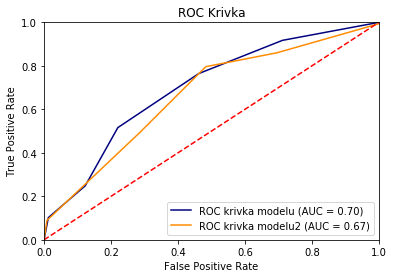

In [18]:
# YOUR CODE HERE

# spocitame parametre ROC krivky pre model2 - pomocou skutocnych hodnot cieloveho atributu a predikcii modelu 2

y_model_probs2 = model2.predict_proba(X_test)
preds2 = y_model_probs2[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test_norm, preds2, pos_label=1) 

# rovnako spocitame AUC koeficient pre model2
roc_auc2 = auc(fpr2, tpr2) 

# vsetky vystupy sme ulozili do premennych identifikovanych cislom 2 - to preto, aby sme neprepisali hodnoty, v ktorych su ulozene koeficienty povodneho modelu

# pomocou matplotlib vykreslíme ROC krivku
plt.title('ROC Krivka') # definujeme názov obrázku
plt.plot(fpr, tpr, 'navy', label = 'ROC krivka modelu (AUC = %0.2f)' % roc_auc) # vykreslíme ROC krivku, navy farbou, vypíšeme do legendy AUC koeficient
plt.plot(fpr2, tpr2, 'darkorange', label = 'ROC krivka modelu2 (AUC = %0.2f)' % roc_auc2) # vykreslíme ROC krivku, navy farbou, vypíšeme do legendy AUC koeficient
plt.legend(loc = 'lower right') # nastavíme vykreslenie legendy vpravo dole
plt.plot([0, 1], [0, 1],'r--') # vykreslíme červenou (r) prerušovanou farbou diagonálu
plt.xlim([0, 1]) # os x bude nadobúdať hodnoty od 0 do 1
plt.ylim([0, 1]) # os y bude nadobúdať hodnoty od 0 do 1
plt.ylabel('True Positive Rate') # jednotlivé osi otitulkujeme
plt.xlabel('False Positive Rate') # jednotlivé osi otitulkujeme
plt.show() # zobrazíme obrázok

#### Úloha 11.3

Skúste teraz model na normalizovaných dátach vyladiť nastavením jeho parametrov. Ako sme si spomínali, pri k-NN algoritme môžeme nastavovať niekoľko parametrov, napr. hodnotu `k`, pre klasifikátor `KNeighborsClassifier` je to parameter:

* `n_neighbors` - zodpovedá hodnote `k`, počet najbližších susedov, podľa ktorých budeme neoznačené príklady klasifikovať

Na konkrétnu hodnotu ho nastavíte pr inicializácii modelu takto: `model = KNeighborsClassifier(n_neighbors=3)`

Skúste postupovať podľa inštrukcií z cvičenia č. 10, tzn. začať s najjednodušším modelom (parameter `k=1'), ktorý budete zvyšovať, až kým sa kvalita modelu neprestane zvyšovať. 

In [25]:
# YOUR CODE HERE

model3 = KNeighborsClassifier(n_neighbors=23)  # Natrénovanie modelu kNN - najvyssie skore ziskaval model niekde okolo hodnoty parametra k 23  
model3.fit(X_train_norm, y_train_norm)         # takyto model natrenujeme na trenovacej mnozine
y_model3 = model3.predict(X_test_norm)          # vypocitame jeho predikcie na testovacich datach

from sklearn.metrics import accuracy_score    # importujeme funkciu pre spocitanie presnosti (ak sme este neimportovali)
print(accuracy_score(y_test_norm, y_model3))   # vypocitame presnost modelu

0.7964376590330788


#### Úloha 11.4

Natrénujte k-NN model na datasete Titanic tak, že na jeho validáciu použijete krížovú validáciu na trénovacej množine. Vyskúšajte pri trénovaní modelov aj vplyv iných parametrov na výslednú kvalitu modelu:

* `weights` - váhovanie, hodnota `uniform` špecifikuje rovnakú váhu hlasu každého z k najbližších susedov, hodnota `distance` váhuje ich vplyv podľa vzdialenosti
* `metric`- špecifikuje používanú metriku, hodnoty napr. `euclidean`, `manhattan`.

Tieto nastavíte napr. takto: `model = KNeighborsClassifier(n_neighbors=10, weights='uniform',metric='manhattan')`. V rámci krížovej validácie spočítajte priemerné `score` modelov. 


Skúste tak nájsť najlepšiu kombináciu parametrov a najlepší z modelov potom otestujte na testovacej množine. Na testovacej množine vypočítajte metriky `accuracy`, `precision`, `recall` a vypíšte `confusion matrix`. 

In [30]:
# YOUR CODE HERE

model4 = KNeighborsClassifier(n_neighbors=22, metric='manhattan', weights='distance')        # Natrénovanie modelu kNN s roznymi parametrami
# najlepsie vysledky mohol davat napr. model s parametrom k 22, pri manhattan metrike pre vypocet vzdialenosti bez vahovania vzdialenosti

from sklearn.model_selection import cross_val_score       # Importujeme potrebnú funkciu pre krizovu validaciu

# krizovou validaciou validujeme model 
score = cross_val_score(model4, X_train_norm, y_train_norm, cv=10)      # Použijeme krížovú validáciu pre model, rozdelením trénovacej množiny Xtrain/ytrain na 5 častí
print(score)  

# model s najlepsimi parametrami natrenujmeme na trenovacich a otestujeme na testovacich datach
model4.fit(X_train_norm, y_train_norm)
y_model4 = model4.predict(X_test_norm)

# vypiseme metriky modelu na testovacich datach - vypis mozeme aj rozumne naformatovat a vypisaeme len tri miesta po desatinnej ciarke (%0.3f)
print("Accuracy: %0.3f" % accuracy_score(y_test_norm, y_model4))
print("Precision: %0.3f" % precision_score(y_test_norm, y_model4))
print("Recall: %0.3f" % recall_score(y_test_norm, y_model4))

[0.75268817 0.75268817 0.83870968 0.81318681 0.78021978 0.79120879
 0.78021978 0.75824176 0.75824176 0.79120879]
Accuracy: 0.791
Precision: 0.759
Recall: 0.701
